In [1]:
import pandas as pd
import os
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import gc

In [4]:
labels_df = pd.read_csv("AllLabels.csv")
labels_df.columns = labels_df.columns.str.strip()  # remove leading/trailing spaces
print(labels_df.columns.tolist())

['ClipID', 'Boredom', 'Engagement', 'Confusion', 'Frustration']


Total clips found: 5052
Average frames per clip: 300.00
Minimum frames: 300
Maximum frames: 300


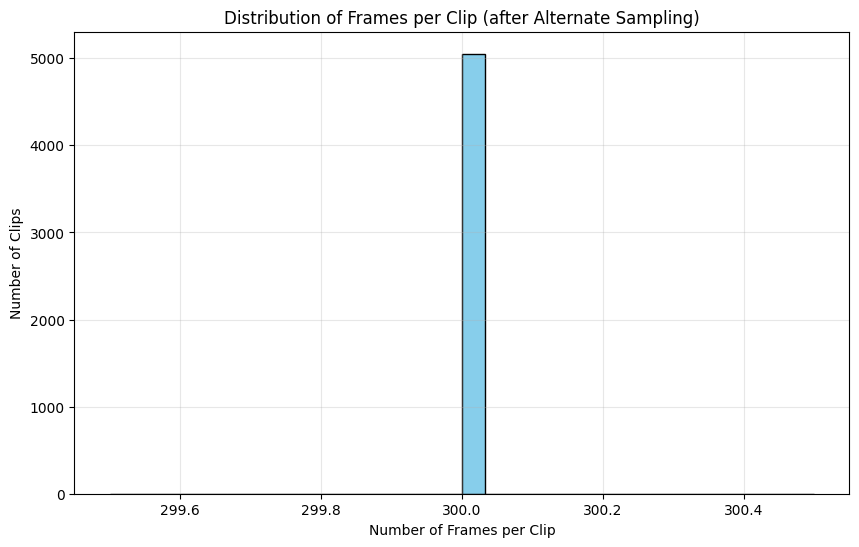

In [9]:
DATA_DIR = r"C:\Users\Randall Chiang\Documents\FYP\DAiSEE\Data\Train"

def count_frames_in_clip(clip_path):
    """Counts frames in a clip folder, optionally applying alternate sampling."""
    frame_files = sorted([f for f in os.listdir(clip_path) if f.endswith(".jpg")])
    return len(frame_files)

# Collect frame counts
frame_counts = []

for root, dirs, files in os.walk(DATA_DIR):
    # if this directory contains .jpg files, it’s a clip folder
    jpg_files = [f for f in files if f.endswith(".jpg")]
    if len(jpg_files) > 0:
        num_frames = count_frames_in_clip(root)
        frame_counts.append(num_frames)

# 🔹 Compute statistics
frame_counts = np.array(frame_counts)
avg_frames = np.mean(frame_counts)
min_frames = np.min(frame_counts)
max_frames = np.max(frame_counts)

print(f"Total clips found: {len(frame_counts)}")
print(f"Average frames per clip: {avg_frames:.2f}")
print(f"Minimum frames: {min_frames}")
print(f"Maximum frames: {max_frames}")

# 🔹 Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(frame_counts, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Frames per Clip (after Alternate Sampling)")
plt.xlabel("Number of Frames per Clip")
plt.ylabel("Number of Clips")
plt.grid(alpha=0.3)
plt.show()


In [6]:
def get_frames_for_clip(clip_path, max_frames=60, img_size=(224, 224), min_frames=5):
    frames = []
    for fname in sorted(os.listdir(clip_path)):
        if fname.endswith(".jpg"):
            img_path = os.path.join(clip_path, fname)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            frames.append(img)

    if len(frames) < min_frames:
        return None  # skip clips with too few frames

    # Trim or pad frames
    if len(frames) > max_frames:
        frames = frames[:max_frames]
    elif len(frames) < max_frames:
        pad = np.zeros((max_frames - len(frames), *img_size, 3), dtype=np.uint8)
        frames.extend(list(pad))

    return np.array(frames, dtype=np.uint8)

DATA_DIR = r"C:\Users\Randall Chiang\Documents\FYP\DAiSEE\Data\Validation"
SAVE_DIR = r"D:\FYP\Validation"
os.makedirs(SAVE_DIR, exist_ok=True)

for i, row in tqdm(labels_df.iterrows(), total=len(labels_df), desc="Processing clips"):
    clip_id = row["ClipID"].replace(".avi", "")
    prefix_folder = clip_id[:6]
    clip_path = os.path.join(DATA_DIR, prefix_folder, clip_id)

    if os.path.exists(clip_path) and os.path.isdir(clip_path):
        frames = get_frames_for_clip(clip_path)
        if frames is not None:
            # Convert to float32 for model input (only per clip)
            frames_float = frames.astype(np.float32) / 255.0

            # Prepare label vector
            label_vec = [
                row["Boredom"],
                row["Engagement"],
                row["Confusion"],
                row["Frustration"]
            ]

            # Save each clip as a separate npz file
            clip_save_path = os.path.join(SAVE_DIR, f"{clip_id}.npz")
            np.savez_compressed(clip_save_path, X=frames_float, y=np.array(label_vec, dtype=np.float32))

            # Free memory
            del frames, frames_float
            gc.collect()

Processing clips: 100%|██████████| 8925/8925 [1:08:37<00:00,  2.17it/s]
